<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23369 entries, 0 to 23368
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_student                   23369 non-null  int64  
 1   num_assessments_total        23369 non-null  int64  
 2   total_score_total            23369 non-null  float64
 3   weighted_score_total         23369 non-null  float64
 4   avg_score_mean               23369 non-null  float64
 5   total_weight_completed       23369 non-null  float64
 6   total_clicks_total           23369 non-null  float64
 7   total_active_days            23369 non-null  float64
 8   avg_clicks_student           23369 non-null  float64
 9   unique_vle_activities_total  23369 non-null  float64
 10  num_of_prev_attempts         23369 non-null  int64  
 11  studied_credits              23369 non-null  int64  
 12  avg_clicks_per_day           23369 non-null  float64
 13  best_result     

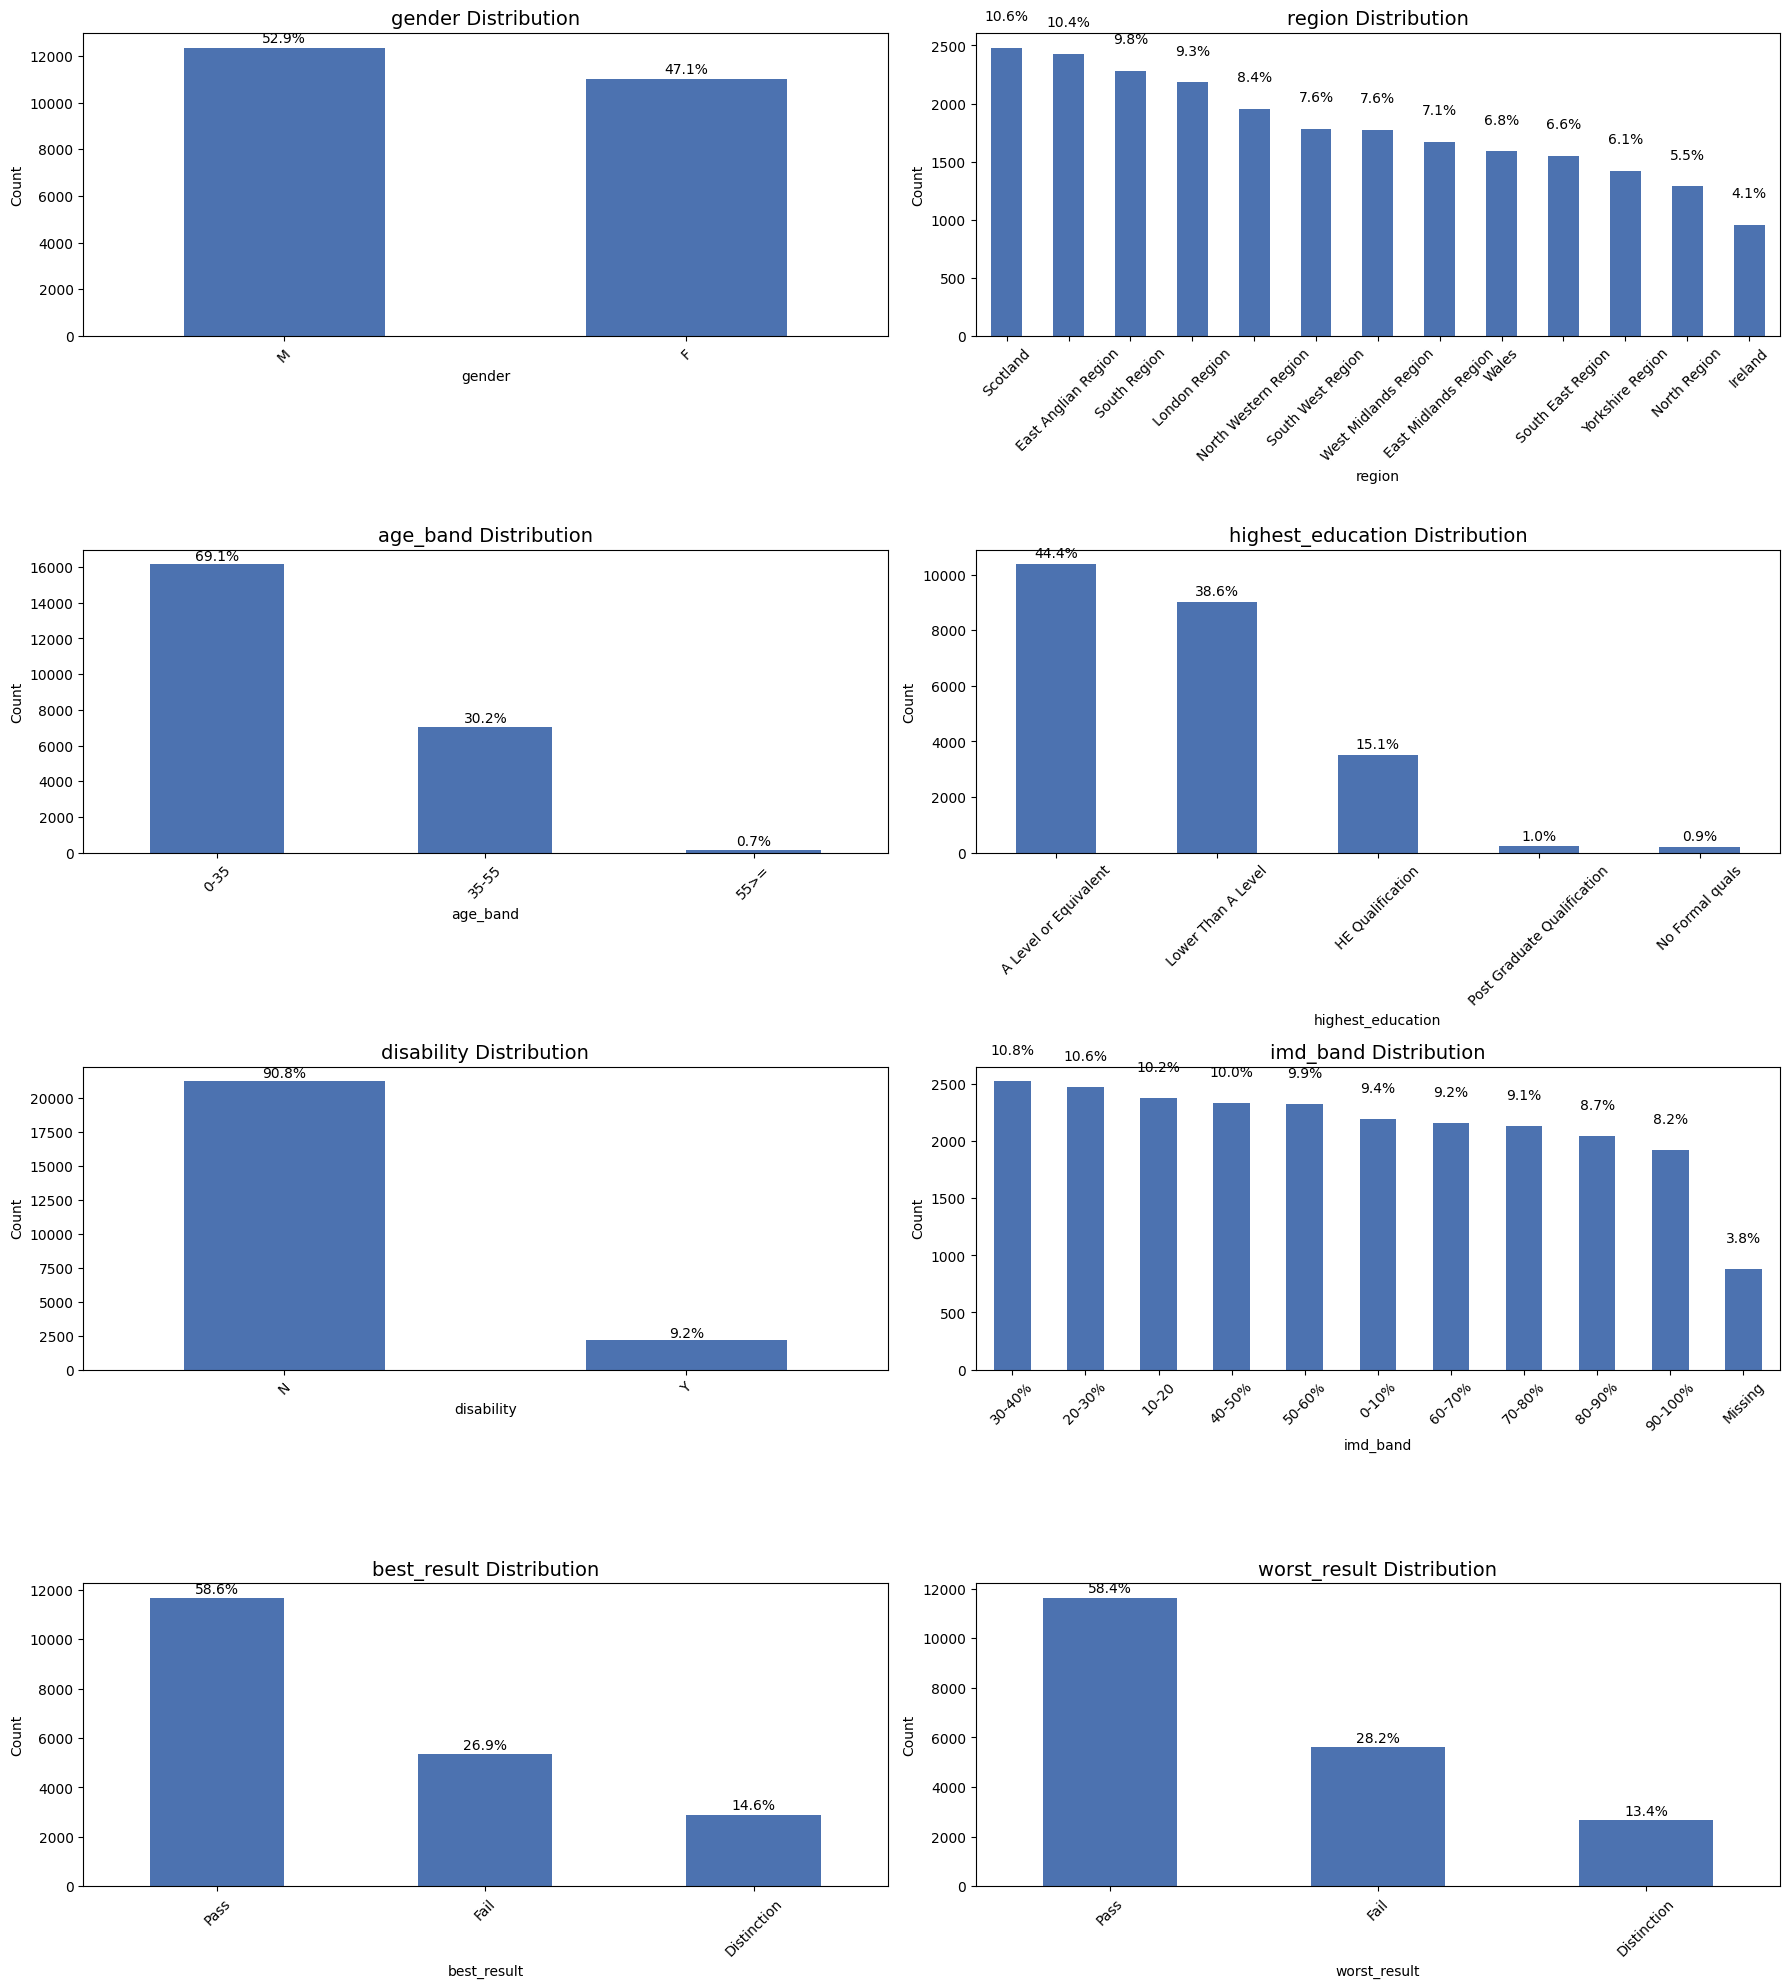

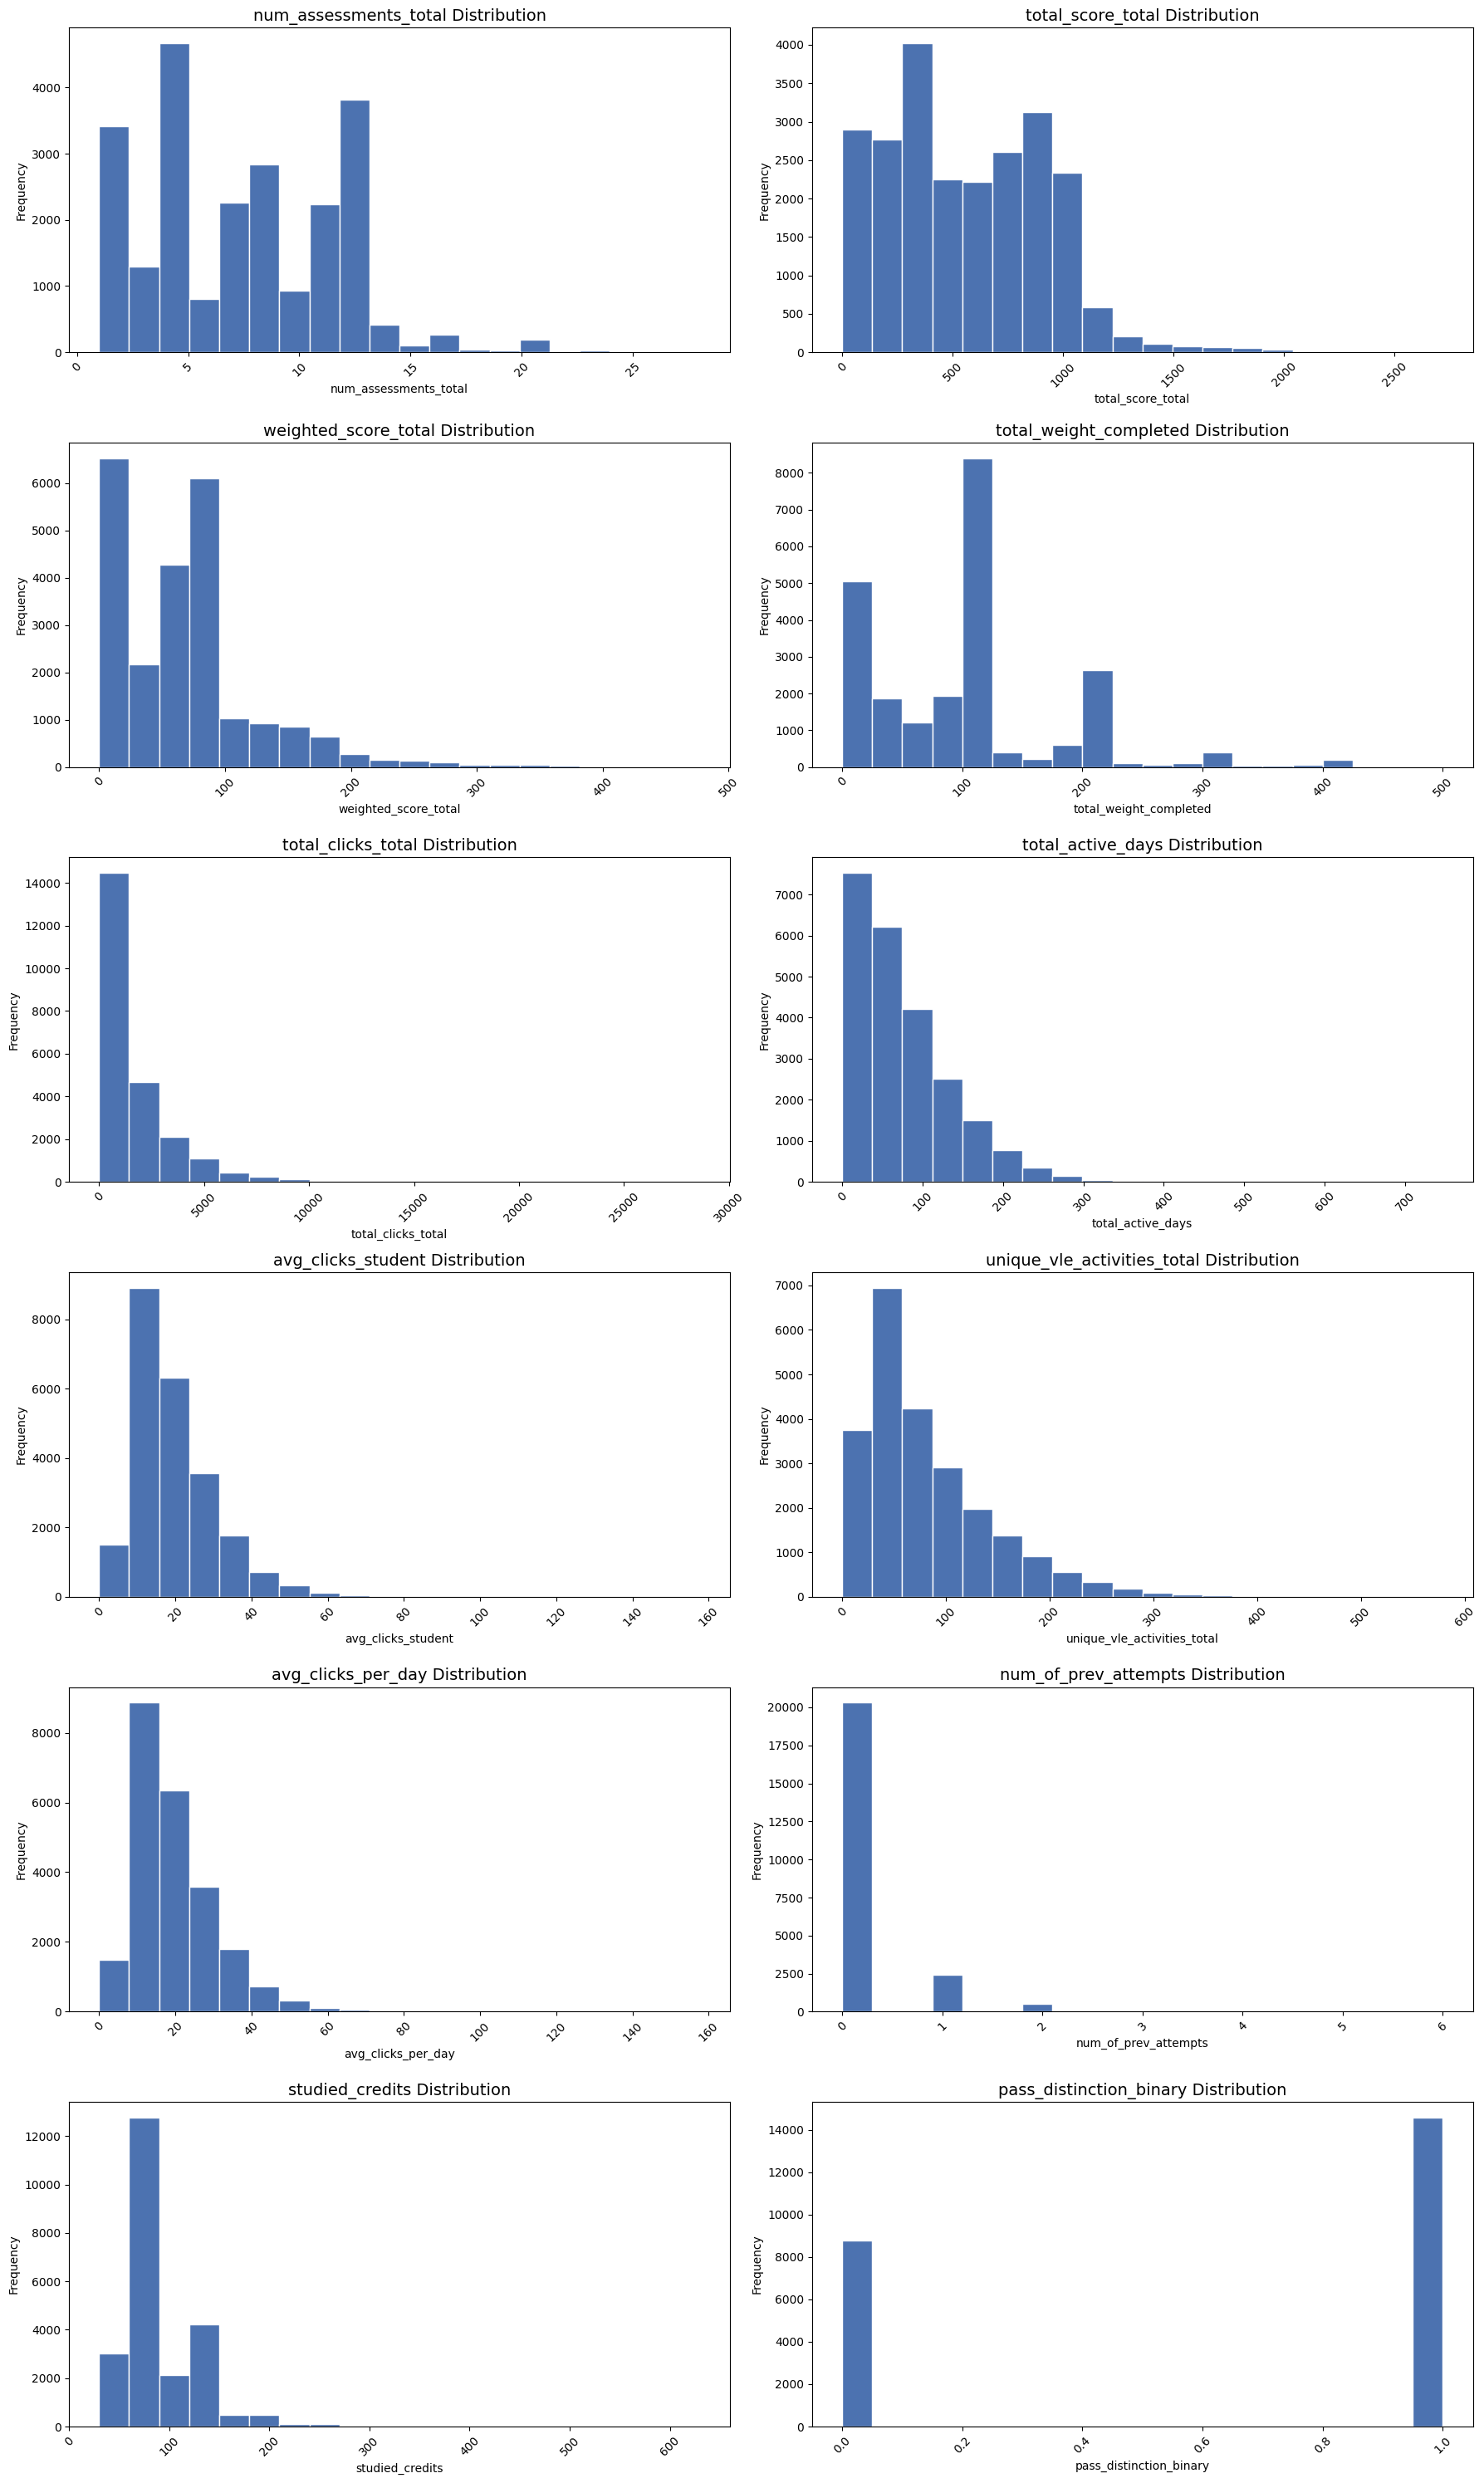

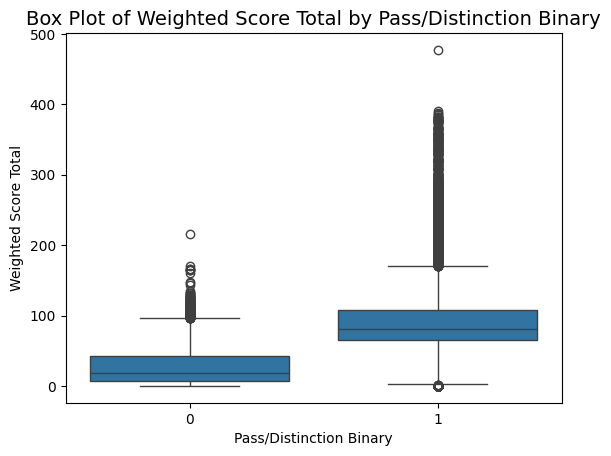

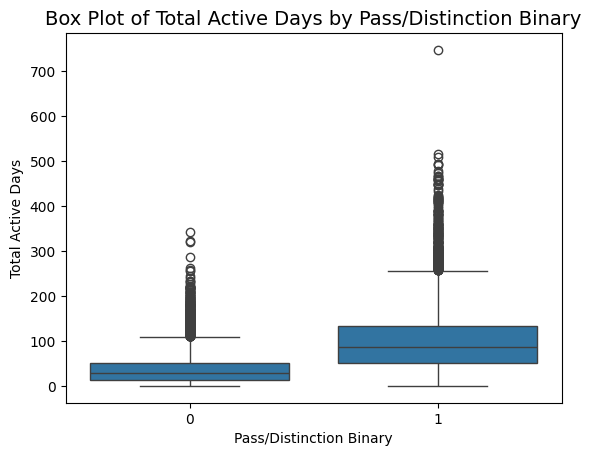

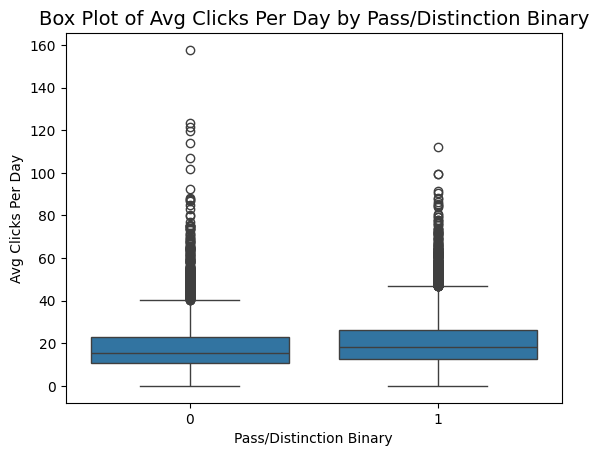

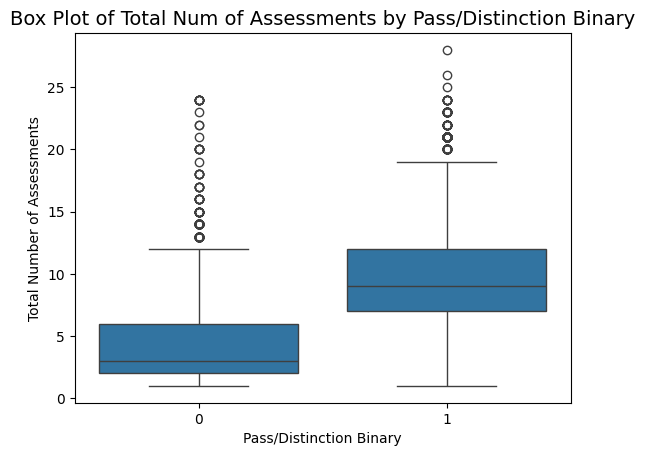

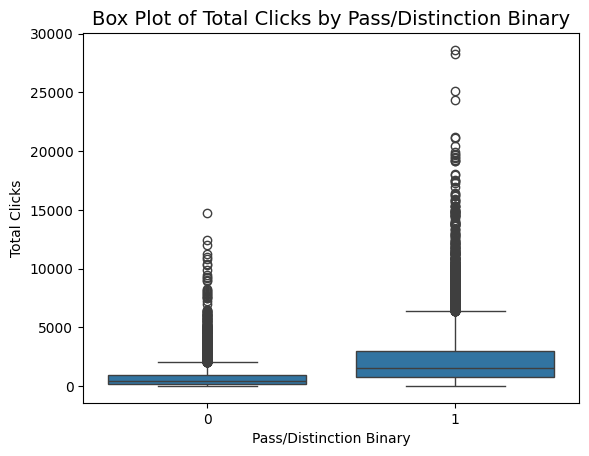

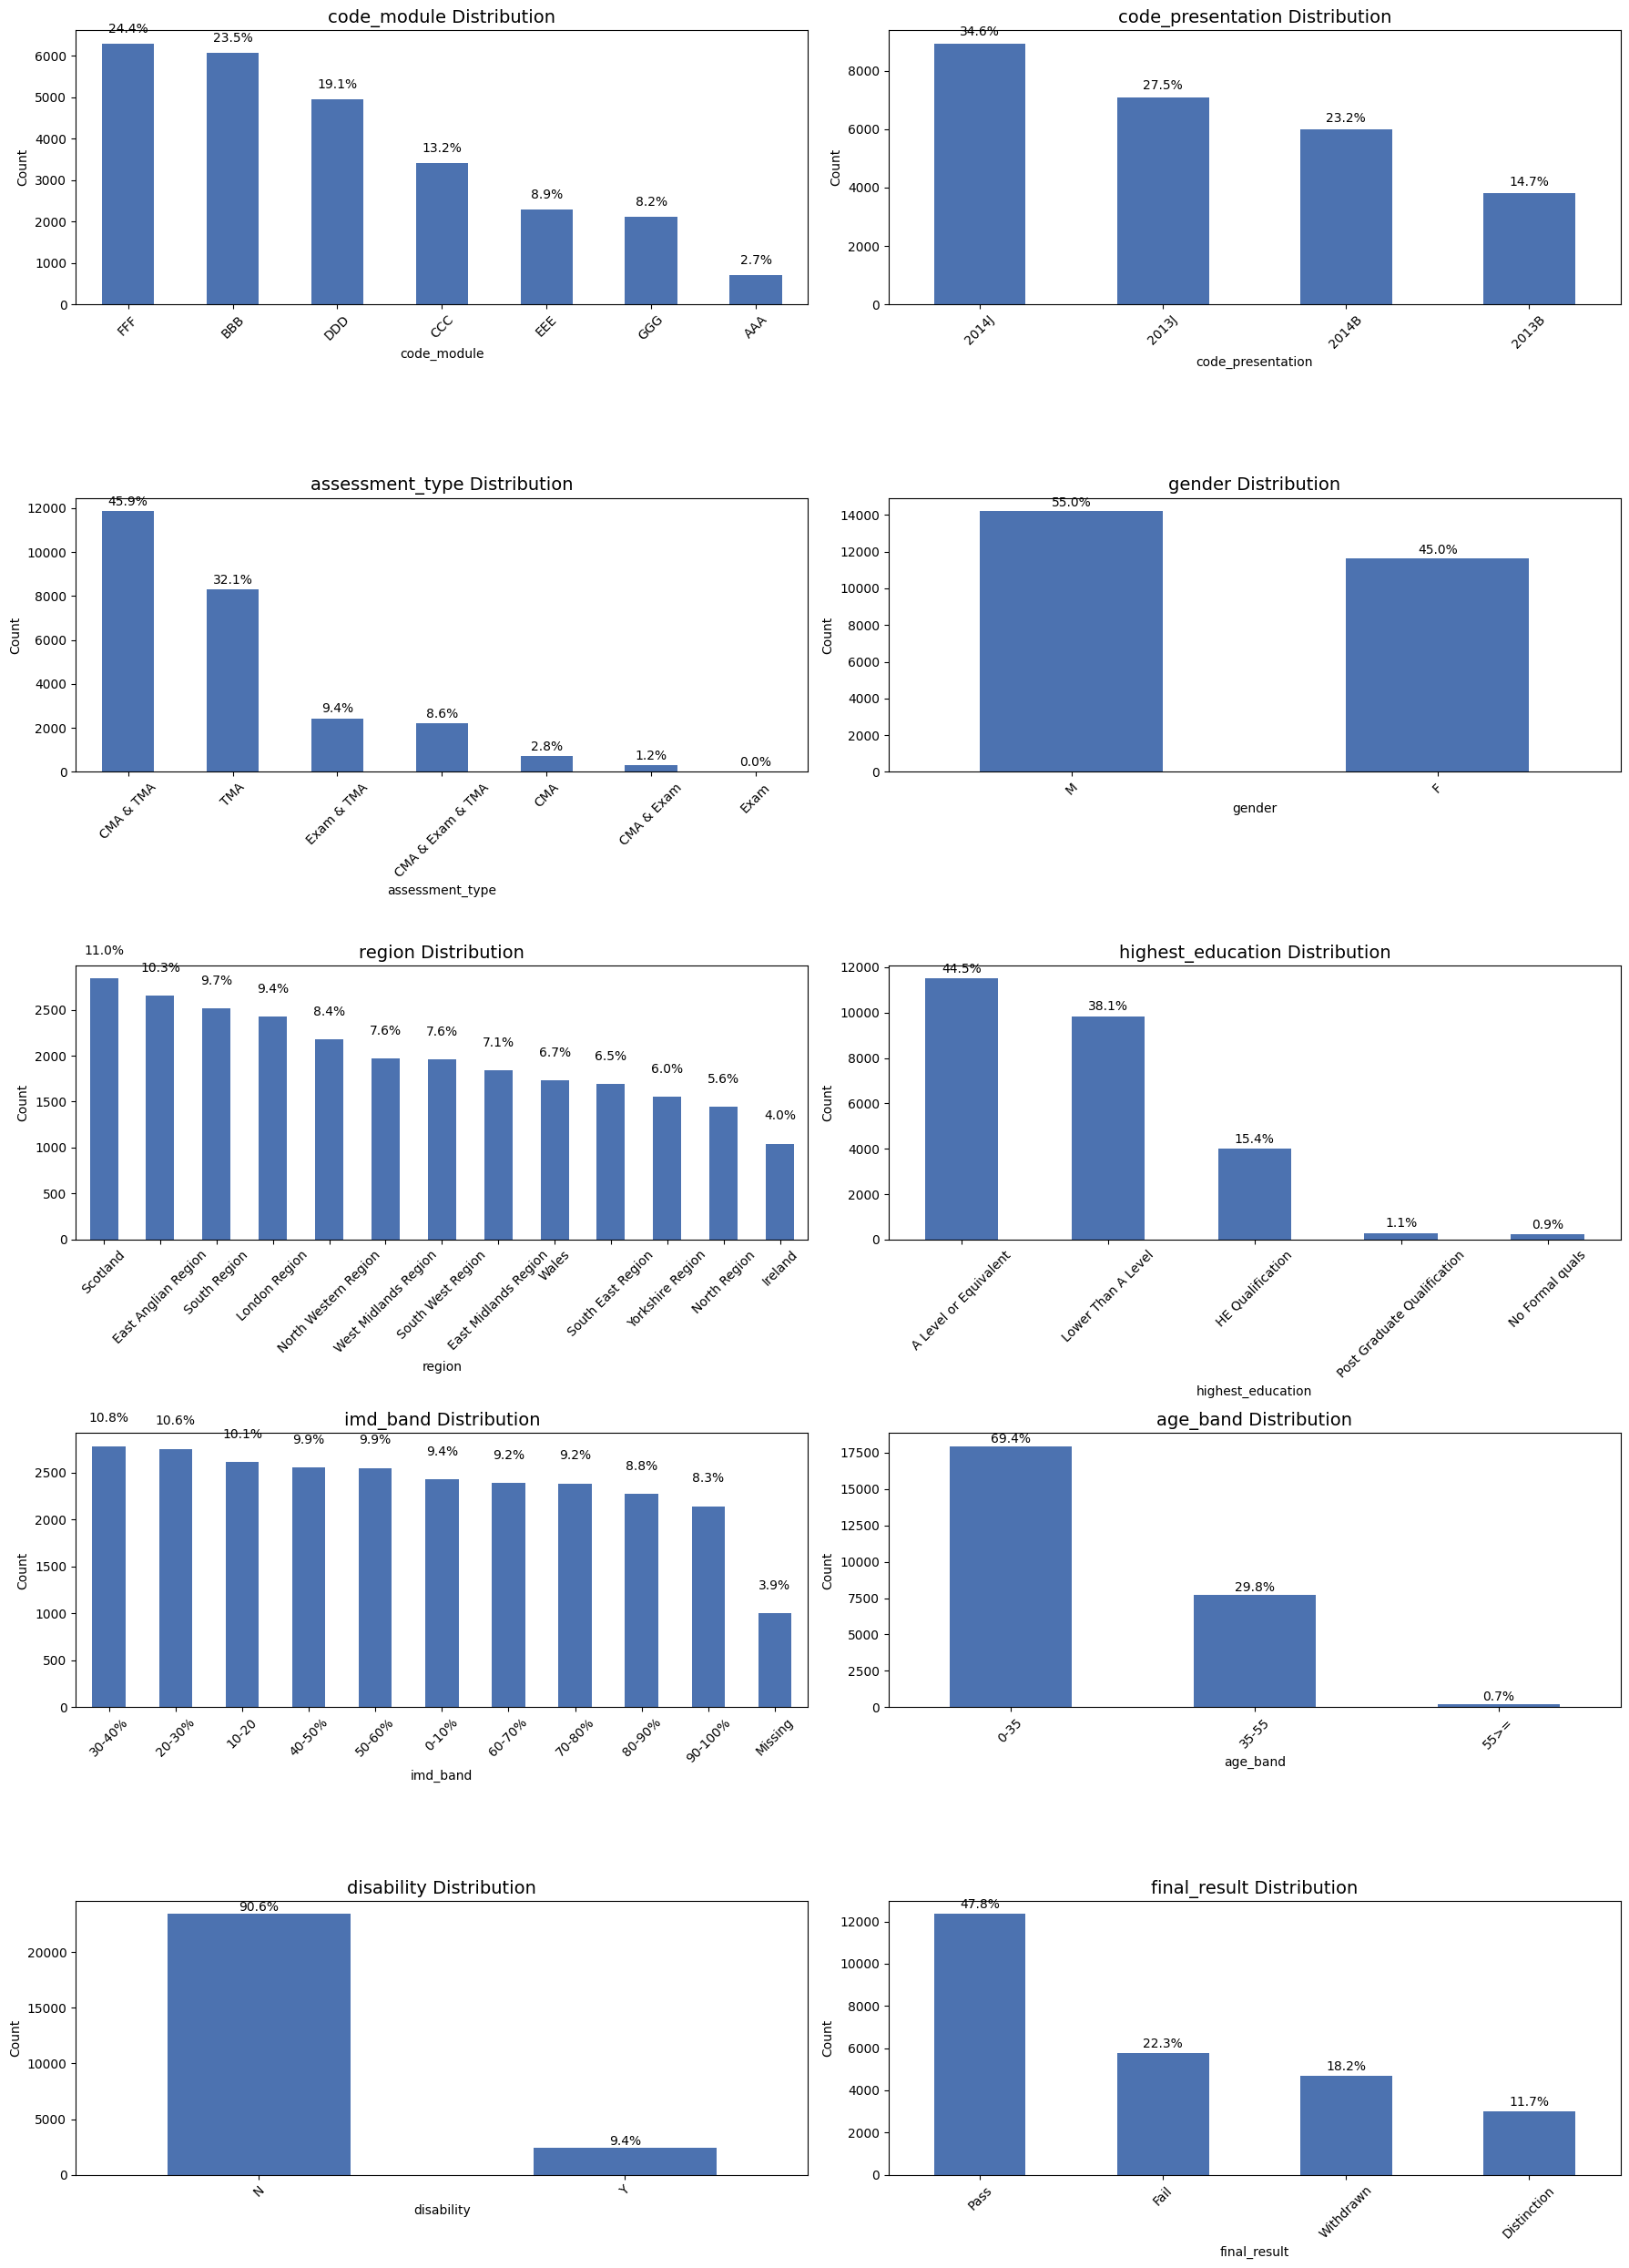

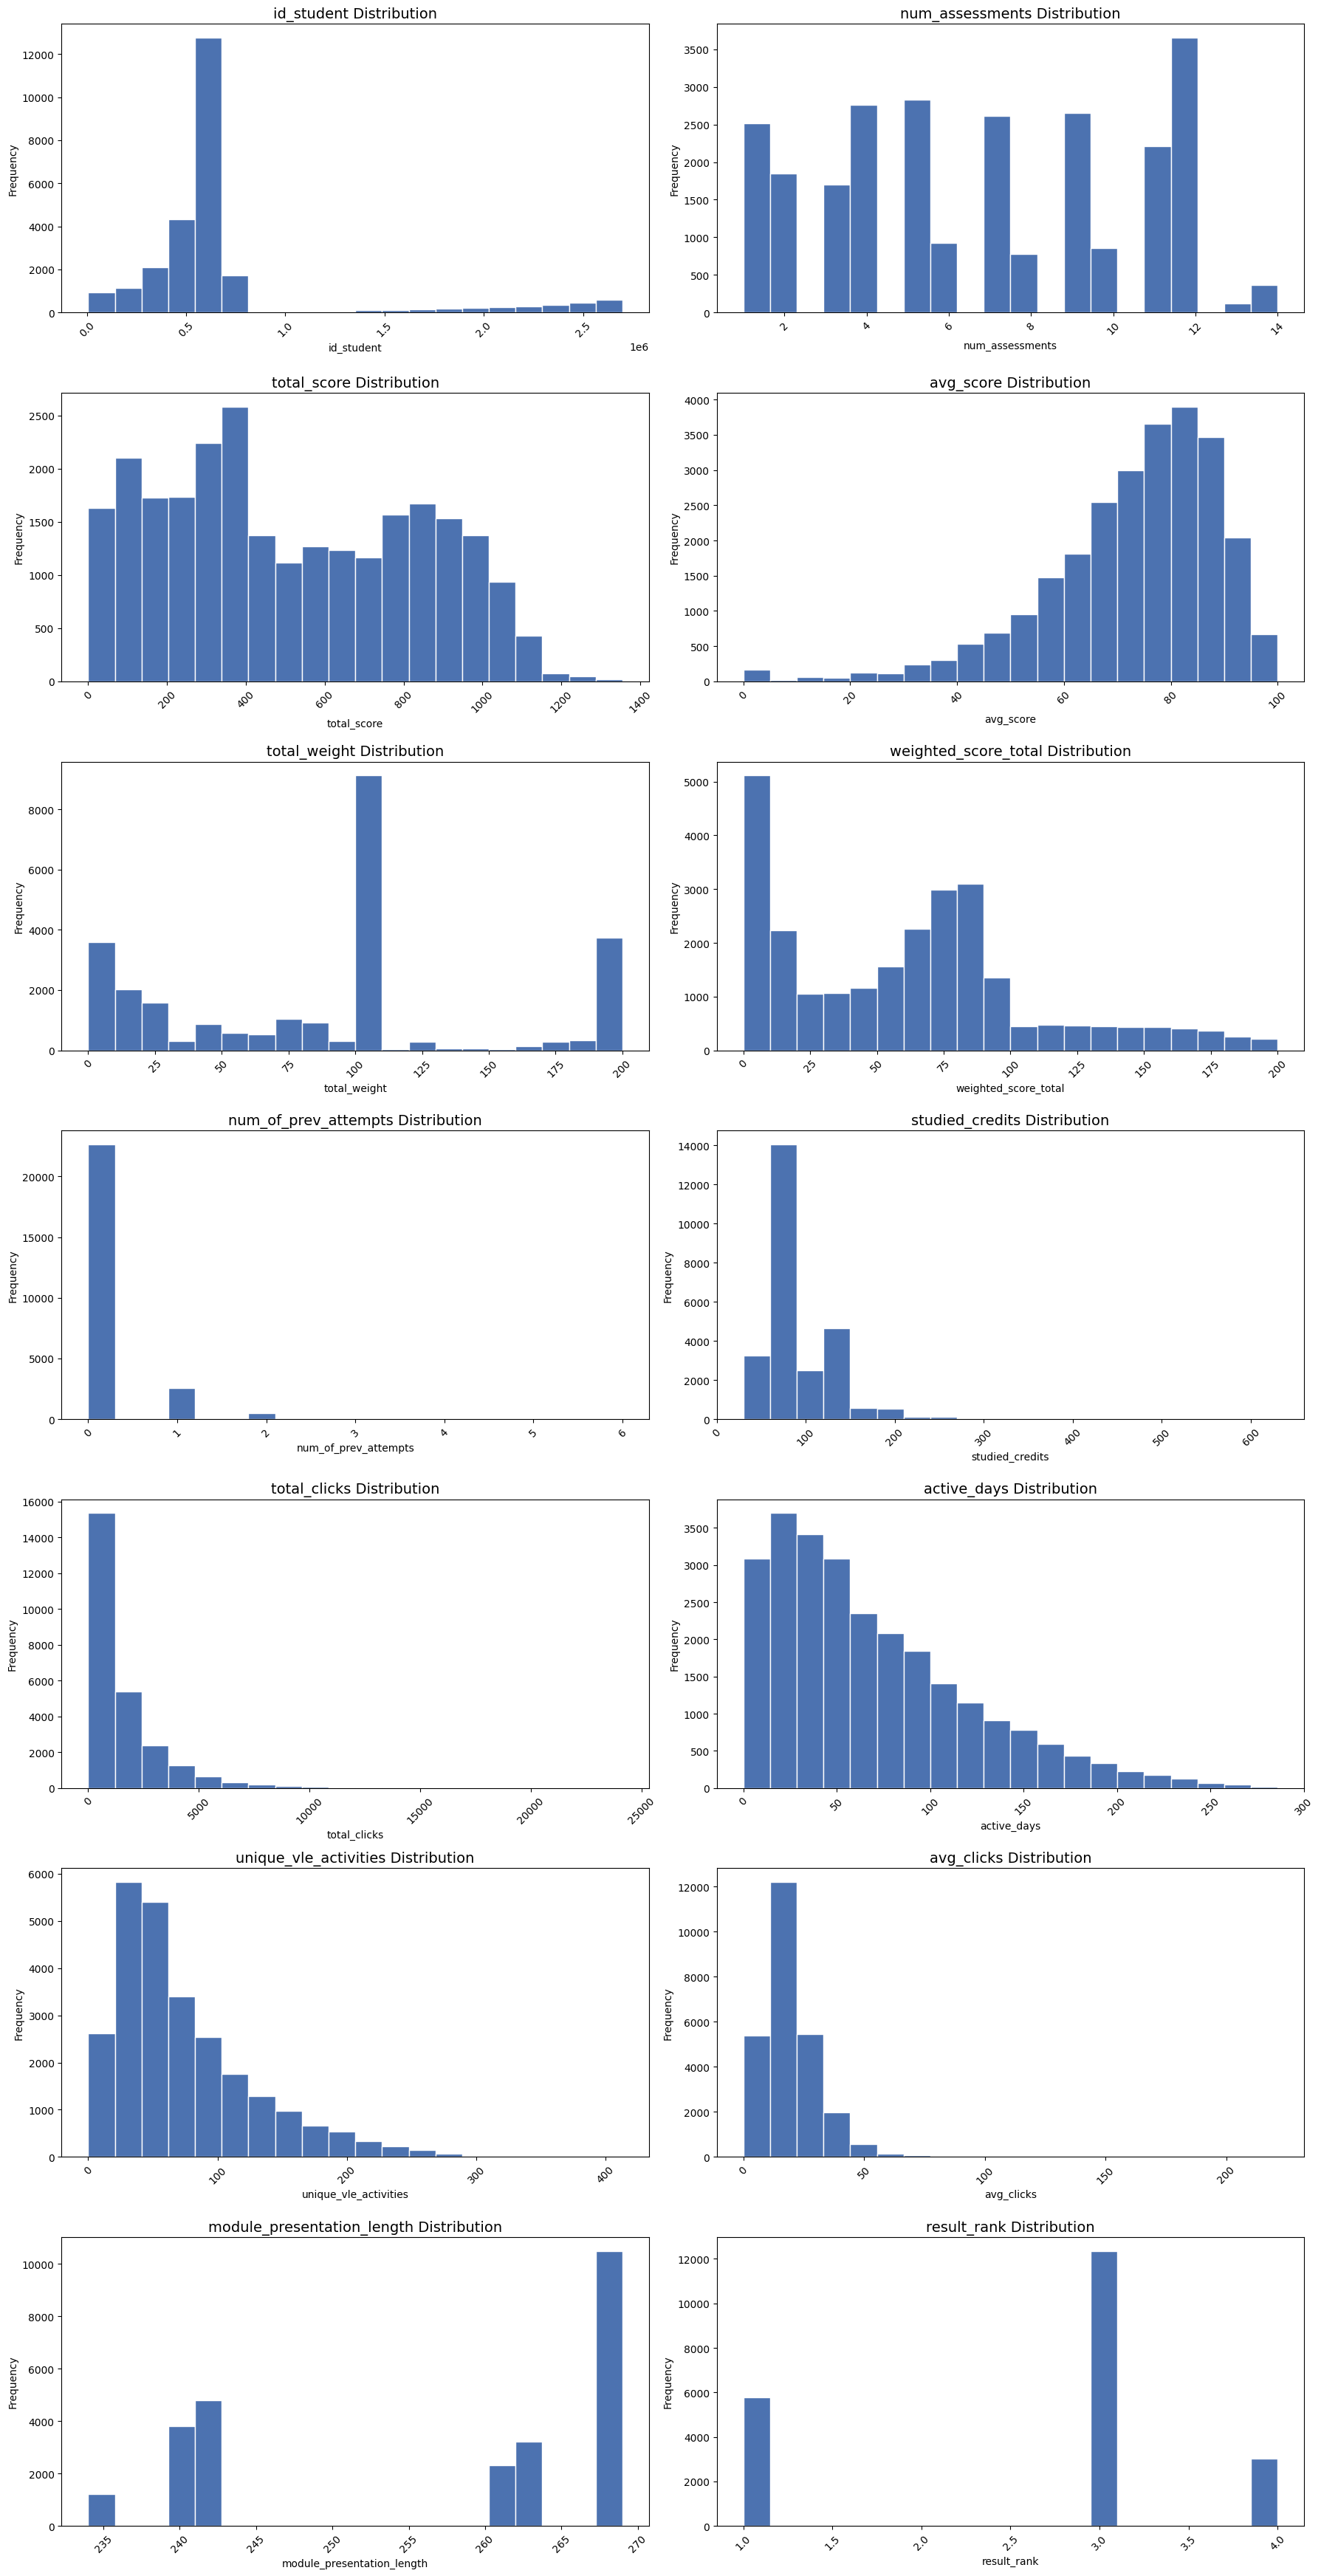


Top 10 student-level predictors of weighted_score_total:
weighted_score_total           1.000000
total_weight_completed         0.948284
total_active_days              0.650858
unique_vle_activities_total    0.596420
total_score_total              0.593856
num_assessments_total          0.571345
pass_distinction_binary        0.531388
total_clicks_total             0.428658
worst_result_Pass              0.342926
best_result_Fail               0.314589
Name: weighted_score_total, dtype: float64

Top 10 student-level predictors of pass_distinction_binary:
pass_distinction_binary    1.000000
best_result_Pass           0.775920
worst_result_Pass          0.773202
best_result_Fail           0.702194
worst_result_Fail          0.670174
total_score_total          0.616165
num_assessments_total      0.571742
weighted_score_total       0.531388
total_weight_completed     0.470780
total_active_days          0.469611
Name: pass_distinction_binary, dtype: float64

Top 10 module-level predictors 

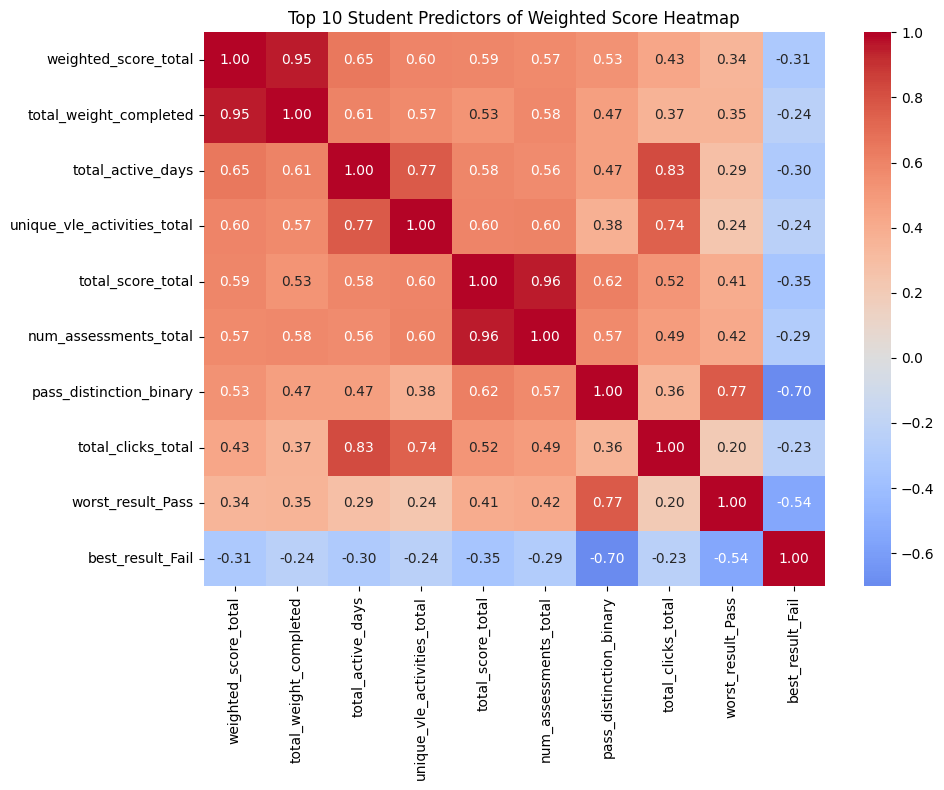

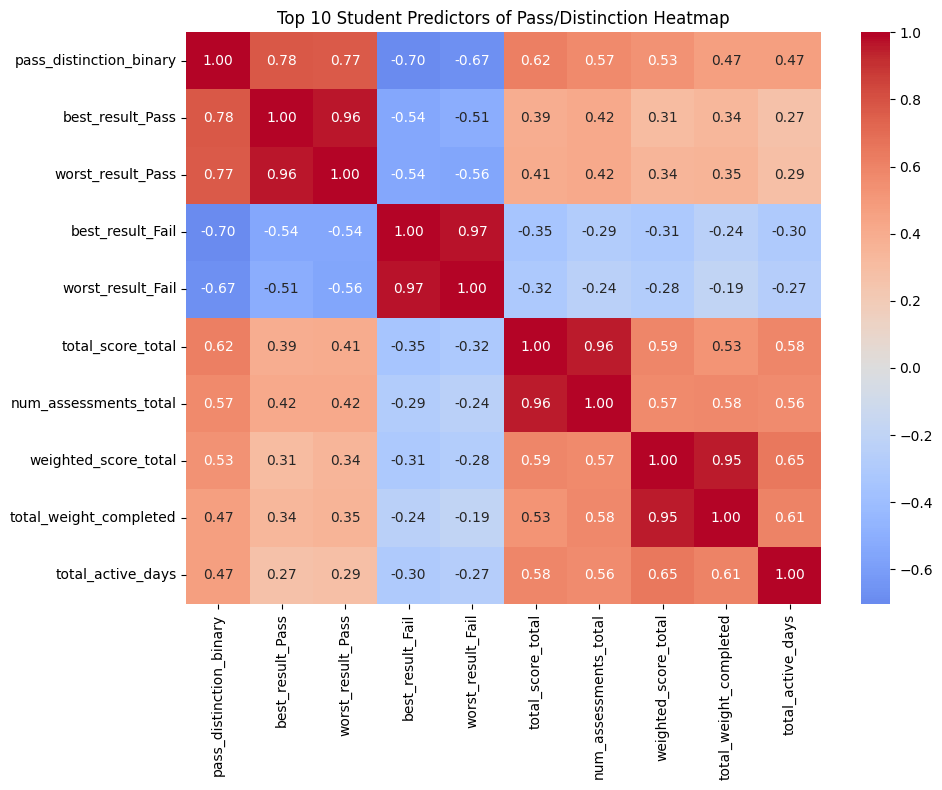

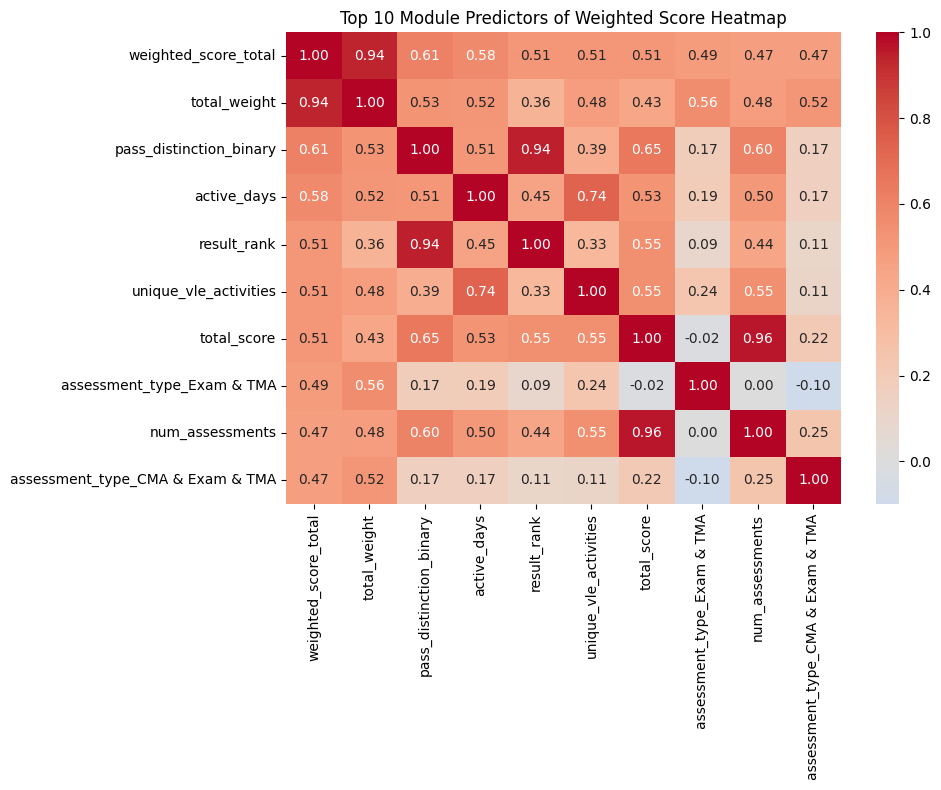

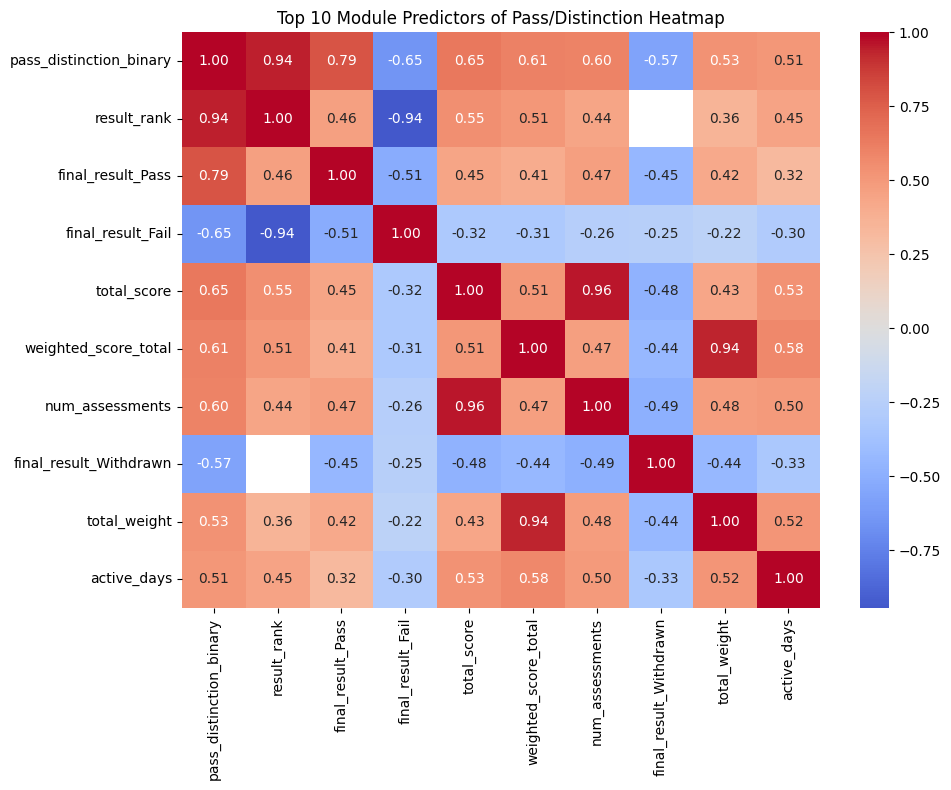


Demographic variables correlation with targets (student level):
                         gender_F  gender_M  age_band_0-35  age_band_35-55  \
weighted_score_total    -0.174600  0.174600      -0.004938       -0.004229   
pass_distinction_binary  0.017898 -0.017898      -0.064259        0.061025   

                         age_band_55>=  imd_band_0-10%  imd_band_10-20  \
weighted_score_total          0.050885       -0.076667       -0.068678   
pass_distinction_binary       0.020166       -0.078120       -0.053717   

                         imd_band_20-30%  imd_band_30-40%  imd_band_40-50%  \
weighted_score_total           -0.036499        -0.010795        -0.017905   
pass_distinction_binary        -0.036326        -0.000964        -0.001432   

                         ...  region_London Region  region_North Region  \
weighted_score_total     ...             -0.019596             0.058907   
pass_distinction_binary  ...             -0.020645             0.022541   

                

In [ ]:
# OULAD Data Preparation & Analysis - Clean Workflow
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load CSV files
# -----------------------------
studentVle = pd.read_csv("studentVle.csv")
assessments = pd.read_csv("assessments.csv")
courses = pd.read_csv("courses.csv")
studentAssessment = pd.read_csv("studentAssessment.csv")
studentInfo = pd.read_csv("studentInfo.csv")
studentRegistration = pd.read_csv("studentRegistration.csv")
vle = pd.read_csv("vle.csv")

# -----------------------------
# 2. Data Cleaning
# -----------------------------
studentInfo["imd_band"].replace({"Oct-20": "10-20%", "Oct 20": "10-20%"}, inplace=True)
studentInfo["imd_band"].fillna("Missing", inplace=True)
studentInfo["age_band"].replace({"55<=": "55>="}, inplace=True)

assessments["date"] = assessments["date"].astype("object")
assessments["date"].fillna("Exam (no due date)", inplace=True)

studentAssessment["score"] = pd.to_numeric(studentAssessment["score"], errors="coerce")
studentAssessment["date_submitted"] = pd.to_numeric(
    studentAssessment["date_submitted"], errors="coerce"
)

studentRegistration["date_registration"] = pd.to_numeric(studentRegistration["date_registration"], errors="coerce")
studentRegistration["date_unregistration"] = pd.to_numeric(studentRegistration["date_unregistration"], errors="coerce")

courses["module_presentation_length"] = pd.to_numeric(courses["module_presentation_length"], errors="coerce")

vle["week_from"] = pd.to_numeric(vle["week_from"], errors="coerce")
vle["week_to"] = pd.to_numeric(vle["week_to"], errors="coerce")

studentVle["date"] = pd.to_numeric(studentVle["date"], errors="coerce")
studentVle["sum_click"] = pd.to_numeric(studentVle["sum_click"], errors="coerce")

# -----------------------------
# 3. VLE Aggregation
# -----------------------------
vle_agg = studentVle.groupby(["id_student", "code_module", "code_presentation"]).agg(
    total_clicks=("sum_click", "sum"),
    active_days=("date", "nunique"),
    unique_vle_activities=("id_site", "nunique")
).reset_index()

vle_agg["avg_clicks"] = (vle_agg["total_clicks"] / vle_agg["active_days"]).fillna(0)

# -----------------------------
# 4. Student Assessment Aggregation
# -----------------------------
studentAssessment_full = studentAssessment.merge(
    assessments[["id_assessment", "code_module", "code_presentation", "assessment_type", "weight"]],
    on="id_assessment",
    how="left"
)

studentAssessment_full = studentAssessment_full.dropna(subset=["code_module", "code_presentation"])

studentAssessment_full["weighted_score"] = (
    studentAssessment_full["score"] * studentAssessment_full["weight"] / 100
)

assessment_agg = studentAssessment_full.groupby(
    ["id_student", "code_module", "code_presentation"]
).agg(
    num_assessments=("id_assessment", "count"),
    total_score=("score", "sum"),
    avg_score=("score", "mean"),
    total_weight=("weight", "sum"),
    weighted_score_total=("weighted_score", "sum")
).reset_index()

assessment_types = studentAssessment_full.groupby(
    ["id_student", "code_module", "code_presentation"]
)["assessment_type"].agg(lambda x: " & ".join(sorted(x.dropna().unique()))).reset_index()

assessment_metrics = assessment_agg.merge(
    assessment_types,
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

# -----------------------------
# 5. Create Master Module-Level DataFrame
# -----------------------------
master_df = assessment_metrics.merge(
    studentInfo,
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

master_df = master_df.merge(
    vle_agg,
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

master_df = master_df.merge(
    courses,
    on=["code_module", "code_presentation"],
    how="left"
)

numeric_cols = [
    "num_assessments", "total_score", "avg_score", "total_weight",
    "weighted_score_total", "total_clicks", "active_days",
    "unique_vle_activities", "avg_clicks"
]
master_df[numeric_cols] = master_df[numeric_cols].fillna(0)

# -----------------------------
# 6. Binary target
# -----------------------------
master_df["pass_distinction_binary"] = master_df["final_result"].isin(
    ["Pass", "Distinction"]
).astype(int)

result_rank = {"Fail": 1, "Withdraw": 2, "Pass": 3, "Distinction": 4}
master_df["result_rank"] = master_df["final_result"].map(result_rank)

# -----------------------------
# 7. Student-Level Aggregation
# -----------------------------
student_module_agg = master_df.groupby("id_student").agg(
    num_assessments_total=("num_assessments", "sum"),
    total_score_total=("total_score", "sum"),
    weighted_score_total=("weighted_score_total", "sum"),
    avg_score_mean=("avg_score", "mean"),
    total_weight_completed=("total_weight", "sum"),
    total_clicks_total=("total_clicks", "sum"),
    total_active_days=("active_days", "sum"),
    avg_clicks_student=("avg_clicks", "mean"),
    unique_vle_activities_total=("unique_vle_activities", "sum"),
    num_of_prev_attempts=("num_of_prev_attempts", "max"),
    studied_credits=("studied_credits", "first")
).reset_index()

student_module_agg["avg_clicks_per_day"] = (
    student_module_agg["total_clicks_total"] / student_module_agg["total_active_days"]
).fillna(0)

final_result_stats = master_df.groupby("id_student").agg(
    best_result_rank=("result_rank", "max"),
    worst_result_rank=("result_rank", "min")
).reset_index()

rank_to_result = {v: k for k, v in result_rank.items()}
final_result_stats["best_result"] = final_result_stats["best_result_rank"].map(rank_to_result)
final_result_stats["worst_result"] = final_result_stats["worst_result_rank"].map(rank_to_result)

demo_cols = ["gender", "age_band", "highest_education", "imd_band", "disability", "region"]
student_demo = master_df[["id_student"] + demo_cols].drop_duplicates(subset="id_student")

student_level_df = student_module_agg.merge(
    final_result_stats[["id_student", "best_result", "worst_result"]],
    on="id_student",
    how="left"
).merge(
    student_demo,
    on="id_student",
    how="left"
)

student_level_df["pass_distinction_binary"] = (
    master_df.groupby("id_student")["pass_distinction_binary"].max().values
)

# -----------------------------
# 8. One-Hot Encoding
# -----------------------------
categorical_cols_student = [
    "gender", "age_band", "highest_education", "imd_band",
    "disability", "region", "best_result", "worst_result"
]

categorical_cols_master = [
    "gender", "age_band", "highest_education", "imd_band",
    "disability", "region", "final_result", "assessment_type"
]

student_level_encoded = pd.get_dummies(student_level_df, columns=categorical_cols_student, drop_first=False)
master_df_encoded = pd.get_dummies(master_df, columns=categorical_cols_master, drop_first=False)

# -----------------------------
# Force dummy columns to numeric
# -----------------------------
for col in student_level_encoded.columns:
    if student_level_encoded[col].dtype == "bool" or student_level_encoded[col].dtype == "object":
        try:
            student_level_encoded[col] = student_level_encoded[col].astype(int)
        except:
            pass

for col in master_df_encoded.columns:
    if master_df_encoded[col].dtype == "bool" or master_df_encoded[col].dtype == "object":
        try:
            master_df_encoded[col] = master_df_encoded[col].astype(int)
        except:
            pass

# Initial review of data distributions for both student_level and module_level dataframes (before hot-encoding)

print(student_level_df.info())
print(student_level_df.describe(include="all"))
print(student_level_df.head(10))
print(student_level_df.tail(10))

print(master_df.info())
print(master_df.describe(include="all"))
print(master_df.head(10))
print(master_df.tail(10))

# Initial plotting functions for categorical and numerical variables for both dataframes to review the dataframes
# -----------------------------
# CATEGORICAL PLOTTING FUNCTION
# -----------------------------
def plot_multiple_categoricals(df, categorical_cols):
    n = len(categorical_cols)
    rows = (n + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        counts = df[col].value_counts()
        total = counts.sum()

        ax = axes[i]
        counts.plot(kind="bar", ax=ax, color="#4C72B0")

        # Add % labels
        for j, v in enumerate(counts):
            pct = (v / total) * 100
            ax.text(j, v + total * 0.01, f"{pct:.1f}%", ha="center")

        ax.set_title(f"{col} Distribution", fontsize=14)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# -----------------------------
# NUMERICAL PLOTTING FUNCTION
# -----------------------------
def plot_multiple_numericals(df, numerical_cols):
    n = len(numerical_cols)
    rows = (n + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        ax = axes[i]

        df[col].plot(
            kind="hist",
            bins=20,
            ax=ax,
            color="#4C72B0",
            edgecolor="white"
        )

        ax.set_title(f"{col} Distribution", fontsize=14)
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.tick_params(axis="x", rotation=45)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# -----------------------------
# STUDENT-LEVEL COLUMN LISTS
# -----------------------------
student_categorical_cols = [
    "gender",
    "region",
    "age_band",
    "highest_education",
    "disability",
    "imd_band",
    "best_result",
    "worst_result"
]

student_numerical_cols = [
    "num_assessments_total", "total_score_total", "weighted_score_total",
    "total_weight_completed", "total_clicks_total", "total_active_days",
    "avg_clicks_student", "unique_vle_activities_total", "avg_clicks_per_day",
    "num_of_prev_attempts", "studied_credits", "pass_distinction_binary"
]

# -----------------------------
# RUN PLOTS FOR STUDENT-LEVEL DF
# -----------------------------
plot_multiple_categoricals(student_level_df, student_categorical_cols)
plot_multiple_numericals(student_level_df, student_numerical_cols)


# Box PLots for numerical columns for student_level_df
# Specific boxplots for key numerical variables against pass_distinction_binary 
sns.boxplot(data=student_level_df, x="pass_distinction_binary", y="weighted_score_total")
plt.title("Box Plot of Weighted Score Total by Pass/Distinction Binary", fontsize=14)
plt.xlabel("Pass/Distinction Binary")
plt.ylabel("Weighted Score Total")
plt.show()

sns.boxplot(data=student_level_df, x="pass_distinction_binary", y="total_active_days")
plt.title("Box Plot of Total Active Days by Pass/Distinction Binary", fontsize=14)
plt.xlabel("Pass/Distinction Binary")
plt.ylabel("Total Active Days")
plt.show()

sns.boxplot(data=student_level_df, x="pass_distinction_binary", y="avg_clicks_per_day")
plt.title("Box Plot of Avg Clicks Per Day by Pass/Distinction Binary", fontsize=14)
plt.xlabel("Pass/Distinction Binary")
plt.ylabel("Avg Clicks Per Day")
plt.show()

sns.boxplot(data=student_level_df, x="pass_distinction_binary", y="num_assessments_total")
plt.title("Box Plot of Total Num of Assessments by Pass/Distinction Binary", fontsize=14)
plt.xlabel("Pass/Distinction Binary")
plt.ylabel("Total Number of Assessments")
plt.show()

sns.boxplot(data=student_level_df, x="pass_distinction_binary", y="total_clicks_total")
plt.title("Box Plot of Total Clicks by Pass/Distinction Binary", fontsize=14)
plt.xlabel("Pass/Distinction Binary")
plt.ylabel("Total Clicks")
plt.show()

# Master.df visualisation
# -----------------------------
# CATEGORICAL PLOTTING FUNCTION
# -----------------------------
def plot_multiple_categoricals(df, categorical_cols):
    n = len(categorical_cols)
    rows = (n + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        counts = df[col].value_counts()
        total = counts.sum()

        ax = axes[i]
        counts.plot(kind="bar", ax=ax, color="#4C72B0")

        for j, v in enumerate(counts):
            pct = (v / total) * 100
            ax.text(j, v + total * 0.01, f"{pct:.1f}%", ha="center")

        ax.set_title(f"{col} Distribution", fontsize=14)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# -----------------------------
# NUMERICAL PLOTTING FUNCTION
# -----------------------------
def plot_multiple_numericals(df, numerical_cols):
    n = len(numerical_cols)
    rows = (n + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        ax = axes[i]

        df[col].plot(
            kind="hist",
            bins=20,
            ax=ax,
            color="#4C72B0",
            edgecolor="white"
        )

        ax.set_title(f"{col} Distribution", fontsize=14)
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.tick_params(axis="x", rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# -----------------------------
# MASTER DF COLUMN LISTS
# -----------------------------
master_categorical_cols = master_df.select_dtypes(include=["object", "category"]).columns
master_numerical_cols = master_df.select_dtypes(include=["int64", "float64"]).columns

# -----------------------------
# RUN PLOTS FOR MASTER DF
# -----------------------------
plot_multiple_categoricals(master_df, master_categorical_cols)
plot_multiple_numericals(master_df, master_numerical_cols)


# -----------------------------
# 9. Correlation matrices
# -----------------------------
student_level_encoded_numeric = student_level_encoded.select_dtypes(include=[np.number])
master_df_encoded_numeric = master_df_encoded.select_dtypes(include=[np.number])

corr_student = student_level_encoded_numeric.corr()
corr_master = master_df_encoded_numeric.corr()

# -----------------------------
# 10. Top 10 correlations
# Summary: Across both student_level and module-Level data the strongest predictors fall into 3 categories:
# 1. Assessment performance metrics (e.g., total_score_total, num_assessments_total, weighted_score_total, total_weight and result_rank)
# 2. VLE engagement metrics (e.g., total_active_days, unique_vle_activities_total, unique_vle_activities, active_days, total_clicks_total,  
# avg_clicks_student)
# 3. Outcome related (e.g. best_result_Pass, worst_result_Pass)
# Summary: Students who complete assessments and engage with the modules are more likely to achieve higher weighted scores and pass.

# -----------------------------
top10_student_weighted = corr_student["weighted_score_total"].abs().sort_values(ascending=False).head(10)
top10_student_pass = corr_student["pass_distinction_binary"].abs().sort_values(ascending=False).head(10)

top10_master_weighted = corr_master["weighted_score_total"].abs().sort_values(ascending=False).head(10)
top10_master_pass = corr_master["pass_distinction_binary"].abs().sort_values(ascending=False).head(10)

print("\nTop 10 student-level predictors of weighted_score_total:")
print(top10_student_weighted)

print("\nTop 10 student-level predictors of pass_distinction_binary:")
print(top10_student_pass)

print("\nTop 10 module-level predictors of weighted_score_total:")
print(top10_master_weighted)

print("\nTop 10 module-level predictors of pass_distinction_binary:")
print(top10_master_pass)

def plot_heatmap(corr_matrix, top10_series, title): 
    vars_to_plot = top10_series.index.tolist() 
    sub_corr = corr_matrix.loc[vars_to_plot, vars_to_plot] 
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(sub_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f") 
    plt.title(title) 
    plt.tight_layout() 
    plt.show() 
    
# Student-level heatmaps 
plot_heatmap(corr_student, top10_student_weighted, 
             "Top 10 Student Predictors of Weighted Score Heatmap") 
plot_heatmap(corr_student, top10_student_pass, 
             "Top 10 Student Predictors of Pass/Distinction Heatmap") 
# Module-level heatmaps 
plot_heatmap(corr_master, top10_master_weighted, 
             "Top 10 Module Predictors of Weighted Score Heatmap") 
plot_heatmap(corr_master, top10_master_pass, 
             "Top 10 Module Predictors of Pass/Distinction Heatmap")

# -----------------------------
# 11. Demographic correlations
# Demographics seem weak predictors compared to assessment and VLE engagement metrics.
# -----------------------------
target_vars = ["weighted_score_total", "pass_distinction_binary"]

demo_cols_student = [
    col for col in student_level_encoded_numeric.columns
    if col.startswith(("gender_", "age_band_", "imd_band_", "region_", "disability_"))
]

demo_cols_master = [
    col for col in master_df_encoded_numeric.columns
    if col.startswith(("gender_", "age_band_", "imd_band_", "region_", "disability_"))
]

print("\nDemographic variables correlation with targets (student level):")
print(corr_student.loc[target_vars, demo_cols_student])

print("\nDemographic variables correlation with targets (module level):")
print(corr_master.loc[target_vars, demo_cols_master])

# -----------------------------
# 12. Save cleaned data for analysis in Powerbi/Tableau
# -----------------------------
master_df.to_csv("OULAD_master_module_level.csv", index=False)
student_level_df.to_csv("OULAD_student_level.csv", index=False)

# Correlation, whilst interesting as an initial review of the data and relationships, is limited in its ability to capture more complex relationships.   
# There is now a need to look more closely at these datasets in terms of their predictive qualities using logistic regression and tree-based models.


# There are 2 datasets:
# student_level_encoded_numeric
# master_df_encoded_numeric

# 2 target variables:
# weighted_score_total ()  which is effectively the numeric score associated with pass_distinction
# pass_distinction_binary 
#  
# Reviewing the columns in both datasets
cols_student=list(student_level_encoded_numeric.columns)
print("Student Level Columns:")
print(cols_student)

# To support interpretability and facilitate analysis and formulating recommendations that are understandable, I am going to focus on the student level dataset. 
# I will create a linear regression for the weighted_score_total and a logistic regression for the pass_distinction_binary

# linear regression and logistic regression for student_level_encoded_numeric dataframe
# linear regression with target = weighted_score_total (which is the numerical equivalent of the final result)


# Check weighted_score_total
print(student_level_encoded_numeric['weighted_score_total'].describe())
student_level_encoded_numeric['weighted_score_total'].dtype

# Modelling Linear Regression and Logistic Regression

# Linear regression code adapted from The Code Institute LMS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------------------------------------------------
# LINEAR REGRESSION: Predict weighted_score_total
# ---------------------------------------------------------

# 1. Drop redundant dummies + the binary equivalent of weighted_score_total (i.e. pass_distinction_binary)to avoid duplication within the model
cols_to_drop_linear = [
    'best_result_Distinction',
    'worst_result_Distinction',
    'highest_education_Lower Than A Level',
    'imd_band_0-10%',
    'age_band_0-35',
    'region_East Anglian Region',
    'pass_distinction_binary'   
]

df_linear = student_level_encoded_numeric.drop(columns=cols_to_drop_linear)

# 2. Prepare features + target
X = df_linear.drop("weighted_score_total", axis=1)
y = df_linear["weighted_score_total"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67
)

# 3. Build linear regression pipeline
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectFromModel(Lasso(alpha=0.001))),
    ("model", LinearRegression())
])

linear_pipeline.fit(X_train, y_train)

# 4. Coefficients
selected_features = X_train.columns[linear_pipeline["selector"].get_support()]
coef = linear_pipeline["model"].coef_

coef_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": coef
}).sort_values("Coefficient", key=abs, ascending=False)

print("\nLinear Regression Coefficients:")
print(coef_df)

# 5. Performance
pred_train = linear_pipeline.predict(X_train)
pred_test = linear_pipeline.predict(X_test)

print("\nTrain R2:", r2_score(y_train, pred_train).round(3))
print("Test R2:", r2_score(y_test, pred_test).round(3))
print("MAE:", mean_absolute_error(y_test, pred_test).round(3))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)).round(3))

coef_df_lin = coef_df.sort_values("Coefficient", key=abs)

plt.figure(figsize=(8, 12))
plt.barh(coef_df_lin["Feature"], coef_df_lin["Coefficient"])
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()



# Both the train and the test model perform extremely well
# Summary from the linear regression show that the students who will achieve 
# the highest final scores are those who:
# - consistenly complete and perform well on (weighted) assessments
# - have a higher level of education prior to undertaking the OU modules
# Conversely, students who will achieve the lower final scores are those who:
# - take many assessment (high workload?)
# - have a history of retaking
# - have lower average scores
# Demographics are still poor predictors of the final (weighted/numerical) outcome  

# Logistic regression using pass_distinction_binary. So repeat the above regression exercise but this time using a classification/binary model
# ---------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Drop redundant dummies + leakage
cols_to_drop_logistic = [
    'best_result_Distinction',
    'worst_result_Distinction',
    'highest_education_Lower Than A Level',
    'imd_band_0-10%',
    'age_band_0-35',
    'region_East Anglian Region',
    'weighted_score_total'   # <-- correct leakage removal
]

df_logistic = student_level_encoded_numeric.drop(columns=cols_to_drop_logistic)

# 2. Prepare features + target
X = df_logistic.drop("pass_distinction_binary", axis=1)
y = df_logistic["pass_distinction_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67
)

# 3. Build logistic regression pipeline
logistic_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectFromModel(LogisticRegression(
        penalty="l1", solver="liblinear", random_state=67
    ))),
    ("model", LogisticRegression(max_iter=500, random_state=67))
])

logistic_pipeline.fit(X_train, y_train)

# 4. Predictions
y_pred = logistic_pipeline.predict(X_test)

# 5. Evaluation
print("Logistic Regression Performance for pass_distinction_binary\n")
print("Accuracy:", accuracy_score(y_test, y_pred).round(3))
print("Precision:", precision_score(y_test, y_pred).round(3))
print("Recall:", recall_score(y_test, y_pred).round(3))
print("F1 Score:", f1_score(y_test, y_pred).round(3))

print("\nConfusion Matrix for logistic regression:")
print(confusion_matrix(y_test, y_pred))

# 6. Selected features + coefficients
selected_features = X_train.columns[logistic_pipeline["selector"].get_support()]
coef = logistic_pipeline["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": coef
}).sort_values("Coefficient", key=abs, ascending=False)

print("\nSelected Features and Coefficients for the Logistic Regression:")
print(coef_df)

#Visdualisation
coef_df_sorted = coef_df.sort_values("Coefficient", key=abs)

plt.figure(figsize=(8, 10))
plt.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"])
plt.xlabel("Coefficient (log-odds)")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

# Both models agree on the same story:
# Engagement matters - avg_clicks_per_day, total_active_days, avg_clicks_student
# Assessment behaviour matters: total_weight_completed, total_Score_total, Num_assessments_total
# Past performance matters: best-result_pass, best_result_Fail
# Demographics have only a modest impact

# Summary:
# Students achieve high final scores and pass the nodules are those who:
# - engage regularly
# - compelte assessments
# - consistently score well on assessments
#-  have a history of passing

# Students are at risk of failing if they are those who:
# - have many atemtps at assessments
# - have a history of failing modules
# - engage less
# - take on heavy credit loads

